# Discrete Tomography


In [ ]:
import skimage as ski
import numpy as np
import matplotlib.pyplot as plt
import os

import utility as util
import astra_wrappers 
import cost_functions 
import reconstruction_alogrithms
import new_solution_generators
import postprocessing

## Loading images

(64, 64)


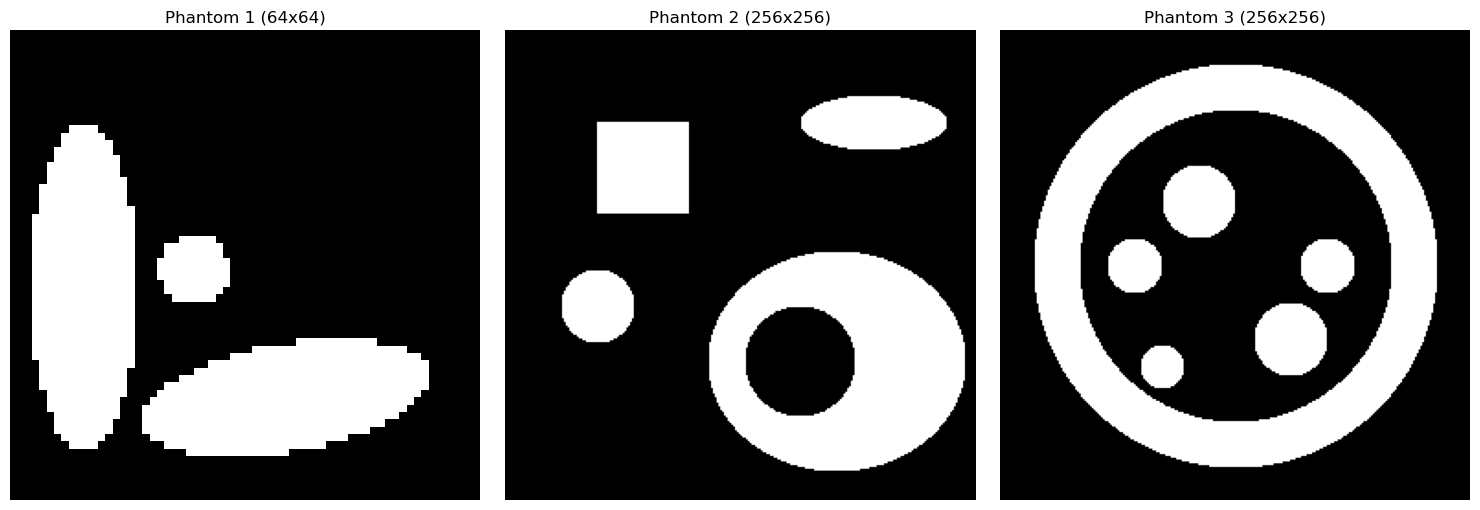

In [6]:
phantom1 = ski.io.imread(os.path.join('data', 'phantom_sz64', 'ph1.png'))
phantom1 = util.fix_img(phantom1)
phantom2 = ski.io.imread(os.path.join('data', 'phantom_sz', 'ph2.png'))
phantom2 = util.fix_img(phantom2)
phantom3 = ski.io.imread(os.path.join('data', 'phantom_sz', 'ph3.png'))
phantom3 = util.fix_img(phantom3)

images = [phantom1, phantom2, phantom3]

titles = [
    f'Phantom 1 ({phantom1.shape[0]}x{phantom1.shape[1]})',
    f'Phantom 2 ({phantom2.shape[0]}x{phantom2.shape[1]})',
    f'Phantom 3 ({phantom3.shape[0]}x{phantom3.shape[1]})'
]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(titles[i])
    ax.axis('off')
plt.tight_layout()
plt.show()

## Generating Test Data

Test data is generated using the **ASTRA Toolbox** via a preprocessing function:

```python
result = preprocess_image(image, show_results=False, angles=None, M=None)  # M being the number of sensors


result = {
    "phantom": img,
    "sinogram": sinogram,
    "rec_art": rec_art,
    "rec_fbp": rec_fbp,
    "system_matrix": W,
    "angles": angles
}
```

### Projection Setup

- **Number of projections** `p ∈ {2, 3, 5, 6}`
  - For `p ∈ {2, 3, 5}`: directions uniformly sampled from `[0°, 90°]`
  - For `p = 6`: directions sampled from `[0°, 150°]`
- **Measurements per direction**:
  - Phantom 1: `96`
  - Phantoms 2 & 3: `384`

### Noise Model

- Both **noiseless** and **noisy** data were used.
- Noise: additive Gaussian `𝒩(0, σ)`, with `σ ∈ {0.5, 1.5, 5}`
- Negative values were **clipped to zero**


In [ ]:
p = [2, 3, 5, 6]
angles = []
for p_val in p:
    angles.append(np.linspace(0, np.pi/2 + np.pi/3*(p_val == 6), num=p_val, endpoint=True))
rng = np.random.default_rng(42) # For reproducibility
M = [96, 384, 384]
std = [0, 0.5, 1.5, 5]

In [ ]:
results = []

for s, projections, thetas, sensors in zip(std, p, angles, M):    
    result = preprocess_image(image, angles=thetas, M=sensors)

    # Add Gaussian noise
    sigma = 1.5
    sinogram = result['sinogram'] + rng.normal(0, sigma, result['sinogram'].shape)
    sinogram = np.clip(noisy_sino, 0, None)

    # Replace sinogram in result
    result['sinogram'] = noisy_sino

    # Evaluate both FBP and ART
    for method in ['rec_fbp', 'rec_art']:
        rec = result[method]
        rec_bin = (rec >= 0.5).astype(np.uint8)

        dice = dice_score(image, rec_bin)
        jaccard = jaccard_index(image, rec_bin)
        e1 = normalized_l1(image, rec_bin)
        e2 = normalized_l2(image, rec_bin)

        results.append({
            'method': method.upper(),
            'p': p,
            'angles_deg': angles_deg.round(2).tolist(),
            'DICE': dice,
            'Jaccard': jaccard,
            'E1 (L1)': e1,
            'E2 (L2)': e2
        })


# 1. Simulated Annealing with Hamming distance neighbours and Gauss regularization cost function

In [19]:
def SA(image):
    """
    Simulated Annealing reconstruction.
    """
    if p < 6:
        angles = np.linspace(0, np.pi/2, p)
    else:
        angles = np.linspace(0, np.pi/2 + np.pi /3, p)

    res = astra_wrappers.preprocess_image(image, angles=angles, M=M)

    # --- Parameters---
    params = {
        "T_start": 4.0,
        "cooling_rate": 0.97,
        "max_iter": 5000,
        "epsilon": 0.00001,
        "verbose": False,

        "sigma": 0.5,  # Standard deviation for Gaussian regularization
        "r": 1,  # Regularization parameter for Gaussian regularization
        "gamma" : 14,
    }

    X0 = astra_wrappers.calculate_X0(res["sinogram"], res["angles"], res["rec_fbp"])

    neighbour_function = new_solution_generators.DeterioratingHammingDistance(
        max_iter=params["max_iter"],
        h_min=1,
        h_max=3
    )

    SA = reconstruction_alogrithms.SimulatedAnnealing(
        X0=X0,
        cost_function=cost_functions.l2_gauss_regularization,
        cost_function_args=(res["system_matrix"], res["sinogram"].ravel(), params["sigma"], params["r"], params["gamma"]),
        neighbour_function=neighbour_function,
        params=params
    )

    # SA.estimate_starting_temperature(100)
        
    best_img, best_cost, cost_history, temp_history = SA.run()
    print(f"Best cost: {best_cost}")
    
    plot_img = [image, best_img]
    plot_titles = ['phantom', 'result']
    util.plot_images(plot_img, plot_titles)

    fig, ax = plt.subplots(2, 1)
    ax = ax.ravel()
    ax[0].plot(cost_history)
    ax[0].set_title('cost history')
    ax[1].plot(temp_history)
    ax[1].set_title('temperature history')


SA1(phantom1, p=5, M=96)



(64, 64)
Best cost: 11.29274671287944


# 2. Simulated Annealing with edge changing neighbours with l2 + tv norm cost

SA.T=np.float64(374.58666648308593)
Best cost: 33.79204463464957


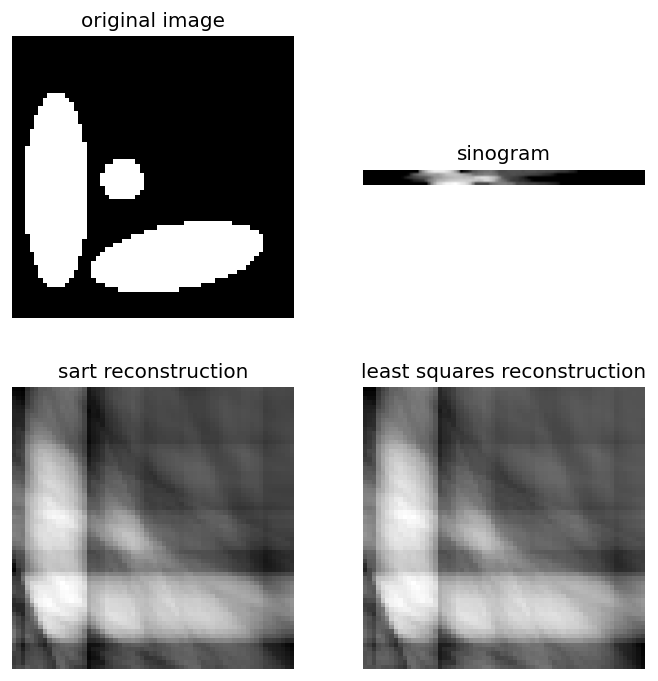

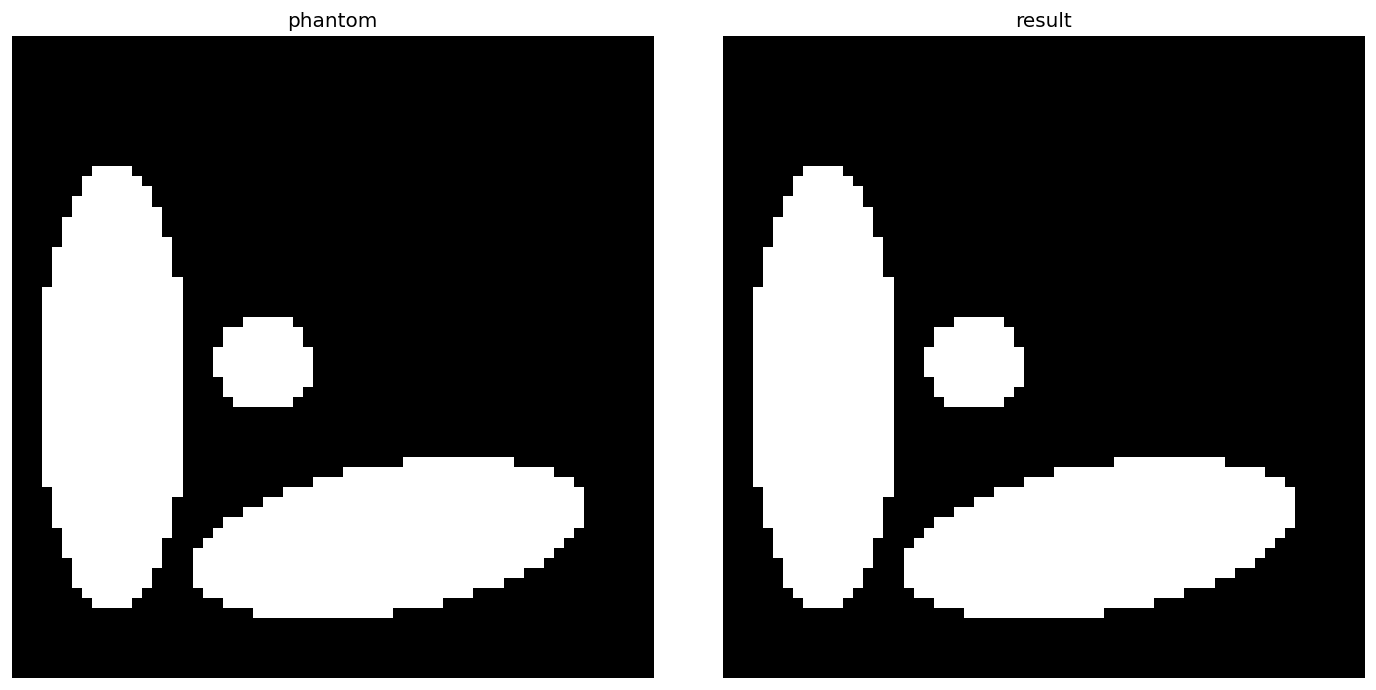

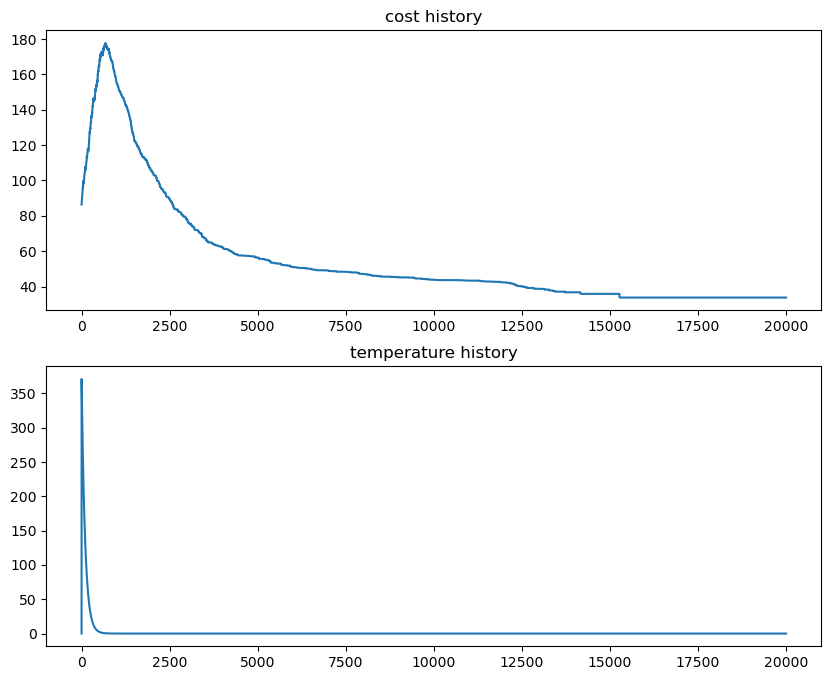

In [25]:
def SA2(image, p, M, params):
    """
    Simulated Annealing reconstruction.
    """
    if p < 6:
        angles = np.linspace(0, np.pi/2, p, endpoint=True)
    else:
        angles = np.linspace(0, np.pi/2 + np.pi /3, p, endpoint=True)

    res = astra_wrappers.preprocess_image(image, angles=angles, M=M, show_results=True)


    X0 = astra_wrappers.calculate_X0(res["sinogram"], res["angles"], res["rec_fbp"])

    neighbour_function = new_solution_generators.DeterioratingHammingDistance(
        max_iter=params["max_iter"],
        h_min=1,
        h_max=3
    )

    neighbour_function = new_solution_generators.FlipOnEdge(
        res["rec_art"],
        params["boundary_recalc_freq"],
    )


    SA = reconstruction_alogrithms.SimulatedAnnealing(
        X0=X0,
        cost_function=cost_functions.l2_and_tv,
        cost_function_args=(res["system_matrix"], res["sinogram"].ravel(), params["lambda_tv"]),
        neighbour_function=neighbour_function,
        params=params
    )

    SA.estimate_starting_temperature(100)
    print(f"{SA.T=}")
        
    best_img, best_cost, cost_history, temp_history = SA.run()
    print(f"Best cost: {best_cost}")
    
    plot_img = [image, best_img]
    plot_titles = ['phantom', 'result']
    util.plot_images(plot_img, plot_titles)

    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax = ax.ravel()
    ax[0].plot(cost_history)
    ax[0].set_title('cost history')
    ax[1].plot(temp_history)
    ax[1].set_title('temperature history')
    

# --- Parameters---
params = {
    "T_start": 0.1,
    "cooling_rate": 0.99,
    "max_iter": 20000,
    "epsilon": 0.00001,
    "verbose": False,

    "lambda_tv": 0.001,

    "boundary_recalc_freq" : 100,
}
SA2(phantom1, p=5, M=96, params=params)

SA.T=np.float64(35256.30851538859)


KeyboardInterrupt: 

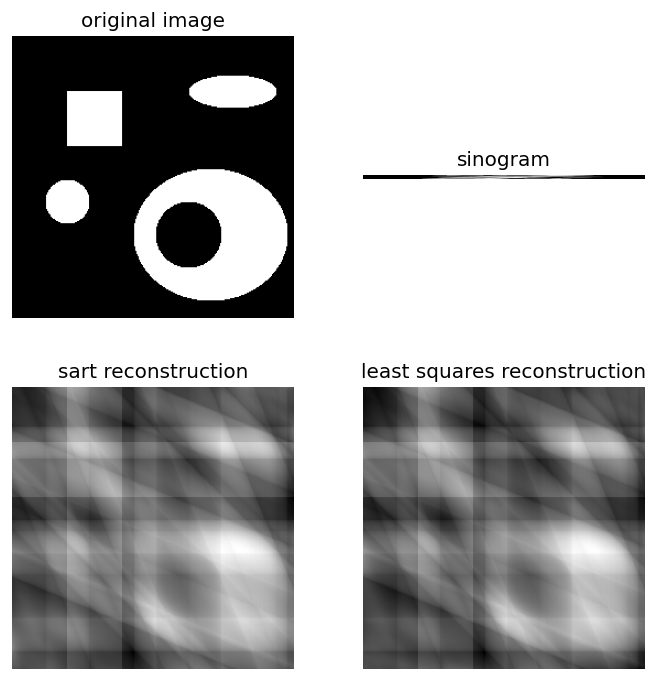

In [26]:

# --- Parameters---
params = {
    "T_start": 10,
    "cooling_rate": 0.999,
    "max_iter": 50000,
    "epsilon": 0.00001,
    "verbose": False,

    "lambda_tv": 0.5,

    "boundary_recalc_freq" : 100,
}
SA2(phantom2, p=5, M=384, params=params)

SA.T=0.1
Best cost: 912.6165252859461


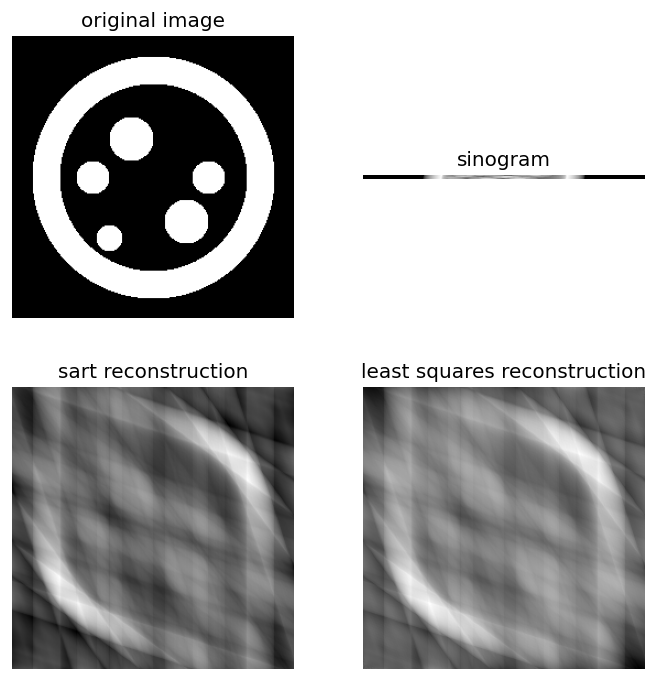

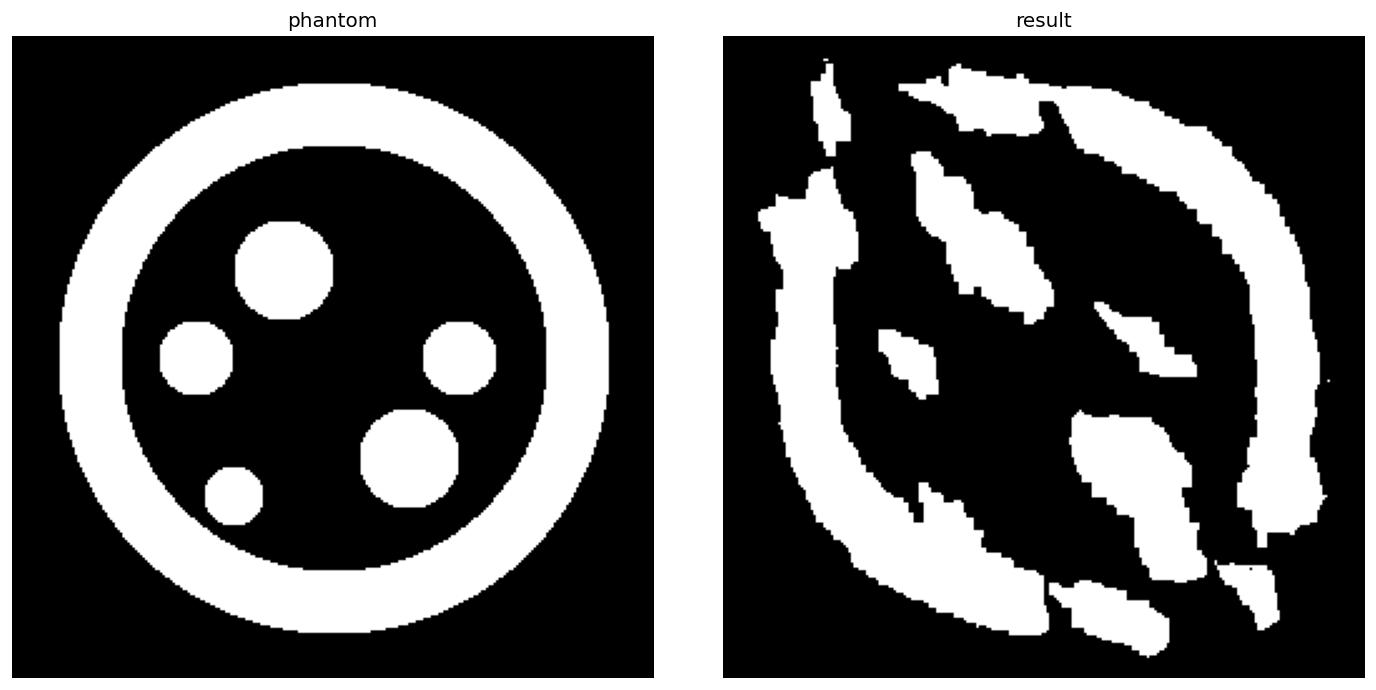

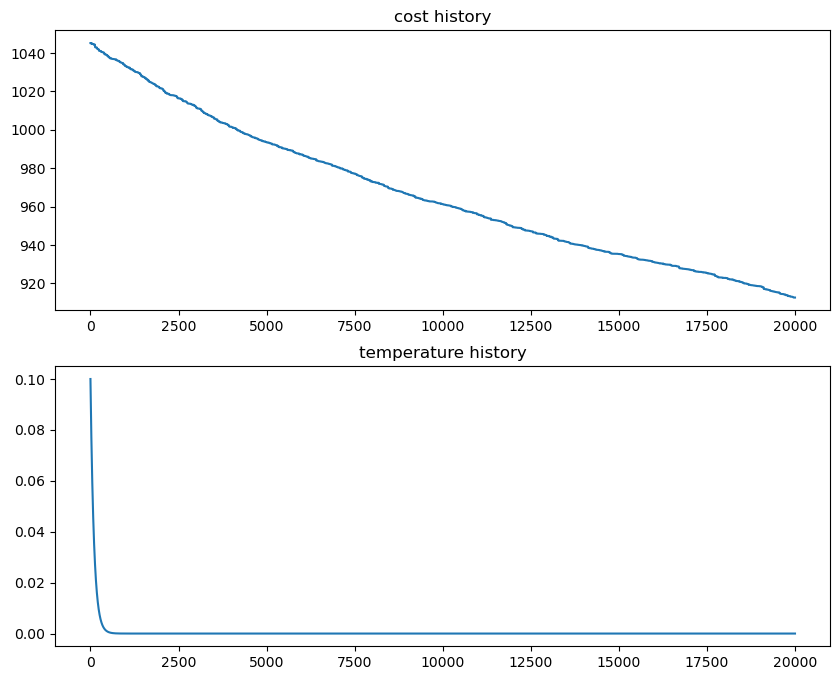

In [23]:
SA2(phantom3, p=5, M=384, params=params)

In [ ]:
def SA3(image, p, M, params):
    """
    Simulated Annealing reconstruction.
    """
    if p < 6:
        angles = np.linspace(0, np.pi/2, p, endpoint=True)
    else:
        angles = np.linspace(0, np.pi/2 + np.pi /3, p, endpoint=True)

    res = astra_wrappers.preprocess_image(image, angles=angles, M=M)


    X0 = astra_wrappers.calculate_X0(res["sinogram"], res["angles"], res["rec_fbp"])

    neighbour_function = new_solution_generators.DeterioratingHammingDistance(
        max_iter=params["max_iter"],
        h_min=1,
        h_max=3
    )

    neighbour_function = new_solution_generators.FlipOnEdge(
        res["rec_art"],
        params["boundary_recalc_freq"],
        fix_high_distance_pixels=True,
        fixed_pixels_per_iter=params["fixed_pixels_per_iter"],
        max_fix_iter=params["max_fix_iter"]
    )


    SA = reconstruction_alogrithms.SimulatedAnnealing(
        X0=X0,
        cost_function=cost_functions.l2_and_tv,
        cost_function_args=(res["system_matrix"], res["sinogram"].ravel(), params["lambda_tv"]),
        neighbour_function=neighbour_function,
        params=params
    )

    SA.estimate_starting_temperature(100)
    print(f"{SA.T=}")
        
    best_img, best_cost, cost_history, temp_history = SA.run()
    print(f"Best cost: {best_cost}")
    
    plot_img = [image, best_img]
    plot_titles = ['phantom', 'result']
    util.plot_images(plot_img, plot_titles)

    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax = ax.ravel()
    ax[0].plot(cost_history)
    ax[0].set_title('cost history')
    ax[1].plot(temp_history)
    ax[1].set_title('temperature history')
    

# --- Parameters---
params = {
    "T_start": 0.1,
    "cooling_rate": 0.99,
    "max_iter": 20000,
    "epsilon": 0.00001,
    "verbose": False,

    "lambda_tv": 0.001,

    "boundary_recalc_freq" : 100,
    "fixed_pixels_per_iter" : 10,
    "max_fix_iter" : 10,
}

SA3(phantom2, p=5, M=384, params=params)

SA.T=np.float64(2584.185342050951)


ValueError: cannot reshape array of size 65536 into shape (16,16)